In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from boruta import BorutaPy

import sys
import os

PROJECT_DIRECTORY = os.path.join(os.getcwd(), '..')
sys.path.append(PROJECT_DIRECTORY)

from src.features_processing import *

In [2]:
abt_treino = pd.read_parquet(PROJECT_DIRECTORY + '/data/processed/abt_treino.parquet')

# Aplicando Tratamento nas variáveis

In [3]:
AUX_VAR_PATH     = PROJECT_DIRECTORY + '/models/artefacts/aux_vars.pickle'
TARGET_VARS_PATH = PROJECT_DIRECTORY + '/models/artefacts/target_vars.pickle'
NUM_VARS_PATH    = PROJECT_DIRECTORY + '/models/artefacts/num_vars.pickle'
CAT_VARS_PATH    = PROJECT_DIRECTORY + '/models/artefacts/cat_vars.pickle'

CAT_IMPUTER_PATH = PROJECT_DIRECTORY + '/models/artefacts/cat_imputer.pickle'
NUM_IMPUTER_PATH = PROJECT_DIRECTORY + '/models/artefacts/num_imputer.pickle'

CAT_ENCONDER_PATH = PROJECT_DIRECTORY + '/models/artefacts/cat_encoder.pickle'
NUM_SCALER_PATH   = PROJECT_DIRECTORY + '/models/artefacts/num_scaler.pickle'


with open(AUX_VAR_PATH,'rb') as f:
    aux_vars = pickle.load(f)

with open(TARGET_VARS_PATH,'rb') as f:
    target_vars = pickle.load(f)

In [4]:
abt_treino = tratamento_completo(df = abt_treino,
                                 aux_vars_path    = AUX_VAR_PATH,
                                 target_var_path  = TARGET_VARS_PATH,
                                 num_vars_path    = NUM_VARS_PATH,
                                 cat_vars_path    = CAT_VARS_PATH,
                                 cat_imputer_path = CAT_IMPUTER_PATH,
                                 num_imputer_path = NUM_IMPUTER_PATH,
                                 cat_encoder_path = CAT_ENCONDER_PATH,
                                 num_scaler_path  = NUM_SCALER_PATH)

abt_treino.head(2)

,id,safra,y,VAR_27,VAR_67,VAR_37,VAR_29,VAR_42,VAR_46,VAR_51,...,onehotencoder__VAR_60_0.219380082347677,onehotencoder__VAR_60_0.242879678877368,onehotencoder__VAR_60_0.319424920164188,onehotencoder__VAR_60_0.357323965312407,onehotencoder__VAR_60_0.412255795406189,onehotencoder__VAR_60_0.534878115446101,onehotencoder__VAR_60_0.648196909605187,onehotencoder__VAR_60_0.721630021341369,onehotencoder__VAR_64_0,onehotencoder__VAR_64_1
0,1,201404,0,-7.041885e-16,4.305728e-01,6.735464e-01,0.565407,1.269366,1.046352,7.067613e-02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,201407,0,2.724741e+00,-9.200442e-17,-6.328688e-17,0.000000,0.000000,0.000000,7.691167e-16,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Preparando base para o feature selection

In [5]:
X = abt_treino.drop(columns=[*aux_vars,*target_vars])
y = abt_treino[target_vars]

# Rodando feature selection

In [6]:
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)

rf.fit(X, y)

importances = rf.feature_importances_

feat_imp = (
    pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .reset_index(drop=True)
)

c:\Users\anima\Desktop\Case_PicPay\.venv\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


# Visualizando variáveis mais importantes

Top 20 Features por importância:
                     feature  importance
0                      VAR_1    0.058862
1                      VAR_6    0.034631
2                      VAR_9    0.032806
3                     VAR_72    0.030867
4                     VAR_65    0.029134
5                     VAR_53    0.027900
6                     VAR_57    0.027888
7                     VAR_30    0.026454
8                     VAR_27    0.025260
9   onehotencoder__VAR_2_0.0    0.023756
10                    VAR_54    0.023529
11                    VAR_38    0.021860
12  onehotencoder__VAR_3_0.0    0.021607
13  onehotencoder__VAR_4_0.0    0.021413
14                     VAR_7    0.021083
15                    VAR_17    0.019974
16                     VAR_5    0.019836
17                    VAR_24    0.019609
18                    VAR_34    0.019507
19                    VAR_52    0.019313


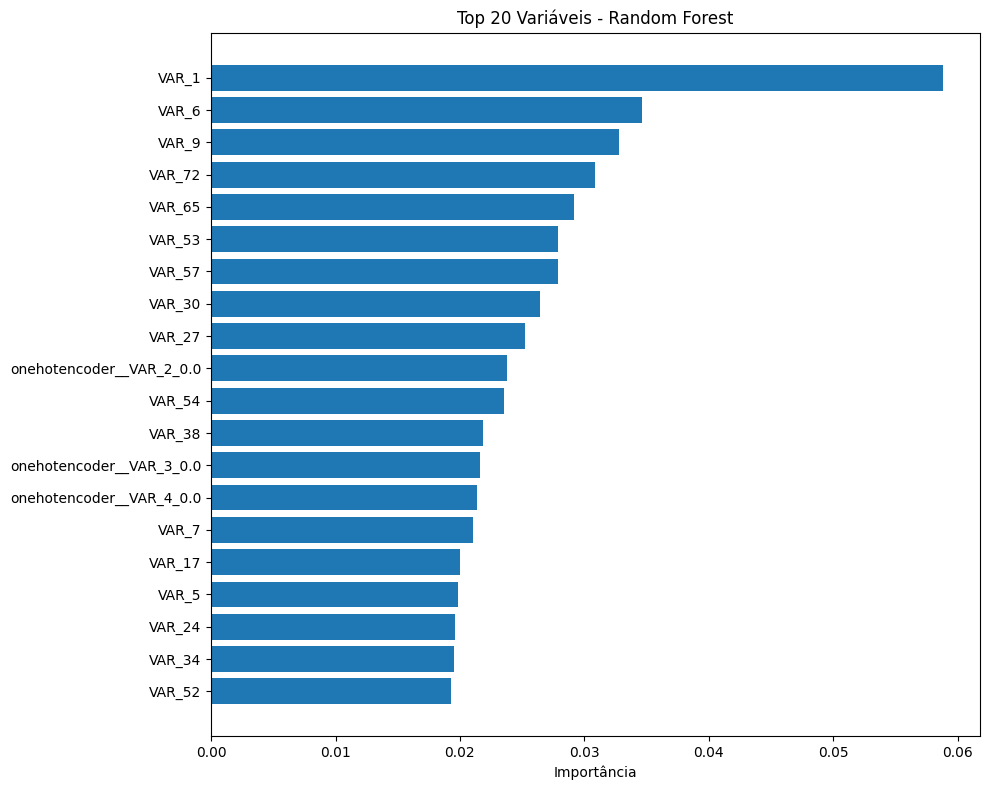

In [7]:
# Lista das 20 Principais Features por Importância
print("Top 20 Features por importância:")
print(feat_imp.head(20))


# Plot das variáveis mais importantes
plt.figure(figsize=(10, 8))
plt.barh(
    feat_imp['feature'][:20][::-1],
    feat_imp['importance'][:20][::-1]
)
plt.xlabel('Importância')
plt.title('Top 20 Variáveis - Random Forest')
plt.tight_layout()

plt.savefig(PROJECT_DIRECTORY + '/reports/top_20_selected_vars.jpeg')
plt.show()

# Aplicando filtro de importância para a seleção final

In [8]:
# Selecionando apenas variáveis com percentual de importância maior que 1,00%
threshold = 0.01

selected_features = feat_imp.loc[
    feat_imp['importance'] > threshold, 'feature'
].tolist()

print(f"\nVariáveis selecionadas (importância > {threshold}):")
print(selected_features)


Variáveis selecionadas (importância > 0.01):
['VAR_1', 'VAR_6', 'VAR_9', 'VAR_72', 'VAR_65', 'VAR_53', 'VAR_57', 'VAR_30', 'VAR_27', 'onehotencoder__VAR_2_0.0', 'VAR_54', 'VAR_38', 'onehotencoder__VAR_3_0.0', 'onehotencoder__VAR_4_0.0', 'VAR_7', 'VAR_17', 'VAR_5', 'VAR_24', 'VAR_34', 'VAR_52', 'VAR_15', 'VAR_35', 'VAR_8', 'VAR_11', 'onehotencoder__VAR_3_1.0', 'VAR_76', 'VAR_13', 'VAR_45', 'VAR_59', 'VAR_14', 'onehotencoder__VAR_2_3.0', 'VAR_51', 'VAR_23', 'VAR_46', 'VAR_37', 'VAR_69', 'VAR_29', 'VAR_42', 'VAR_67', 'VAR_66', 'onehotencoder__VAR_4_1.0', 'onehotencoder__VAR_20_12']


# Salvando lista final de variáveis para modelagem 

In [9]:
SELECTED_VARS_PATH = PROJECT_DIRECTORY + '/models/artefacts/selected_vars.pickle'

with open(SELECTED_VARS_PATH,'wb') as f:
    pickle.dump(selected_features,f)